In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('word_tokenize')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

from typing import List, Dict, Union, Callable

[nltk_data] Downloading package stopwords to /home/alnprd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /home/alnprd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alnprd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alnprd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
def clean_text(x: str, stop_words: nltk.corpus.reader.wordlist.WordListCorpusReader) -> List[str]:
    """Tokenize, remove stop words, lemmatize, drop 'empty' tokens, drop non-alphanumeric characters.
    
    Args:
        x (str): a string of tokens.
        stop_words (nltk.corpus.reader.wordlist.WordListCorpusReader): a corpus of stop words.
        
    Returns:
        x (List[str]): cleaned text.
    """
    x = word_tokenize(x)
    x = [w for w in x if not w in stop_words]
    x = [lemmatizer.lemmatize(w) for w in x]
    x = [w for w in x if w != ""]
    x = [w for w in x if w.isalpha()]

    return x

def rating_to_cat(x: int) -> str:
    """Turn a 0-10 review scale to categorical values.
    
    Args:
        x (int): a number between 1 and 10.
    
    Returns:
        a value in [abysmal, bad, average, good, amazing].
    """
    if x in [1, 2]:
        return "abysmal"
    elif x in [3, 4]:
        return "bad"
    elif x in [5, 6]:
        return "average"
    elif x in [7, 8]:
        return "good"
    else:
        return "amazing"
    
def rating_to_5_scale(x: int) -> int:
    """Turn a 0-10 review scale to a 1-5 scale (like starts).
    
    Args:
        x (int): a number between 1 and 10.
    
    Returns:
        a value between 1 and 5.
    """
    if x in [1, 2]:
        return 1
    elif x in [3, 4]:
        return 2
    elif x in [5, 6]:
        return 3
    elif x in [7, 8]:
        return 4
    else:
        return 5

In [5]:
df = pd.read_csv("../src/data/rop.csv")
df.head()

,review_rating,user_name,review_date,review_title,review_text,num_helpful_reactions,num_total_reactions,episode_number,season_number
0,6.0,Dannyboi942,2 September 2022,"Better than the first episode, but still miss...",Adrift is a better episode than the choppy fir...,111.0,196.0,2,1
1,8.0,TheOne7462,2 September 2022,Hopeful,First two episodes are good. On a technical as...,175.0,326.0,2,1
2,6.0,johndavidson-18,8 September 2022,"Watchable, tolkien adjacent fantasy",This second episode of the series confirms wit...,13.0,18.0,2,1
3,3.0,vaderis3,3 September 2022,Weak tea,Neither better nor worse than the first episod...,22.0,41.0,2,1
4,6.0,quiqueperezsoler3,3 September 2022,An in-depth episode review. Summary: The plot...,The arrival of a being from the sky builds up ...,7.0,11.0,2,1


In [6]:
# Remove reviews without a rating
df = df.dropna(subset=["review_rating"])

# Get date from string
df["review_date"] = df["review_date"].apply(lambda x: datetime.strptime(x, "%d %B %Y"))

# I want to restrict these float values to integers because they are real numbers
df["num_helpful_reactions"] = df["num_helpful_reactions"].astype(int)
df["num_total_reactions"] = df["num_total_reactions"].astype(int)
df["review_rating"] = df["review_rating"].astype(int)

# I want to derive a ratio to denote the appreciation of a review (goes from 0 to 100)
df["review_score"] = round(df["num_helpful_reactions"] / df["num_total_reactions"] * 100, 2)

# Keep original text in place
# I want to lowercase all the text.
df["review_title_original"] = df["review_title"]
df["review_text_original"] = df["review_text"]

# I want to lowercase all the text.
df["review_title"] = df["review_title"].apply(lambda x: x.lower())
df["review_text"] = df["review_text"].apply(lambda x: x.lower())

# Get length of non-tokenized title and text
df["review_title_len_no_token"] = df["review_title"].apply(lambda x: len(x))
df["review_text_len_no_token"] = df["review_text"].apply(lambda x: len(x))

# I want to get the full text including title and review itself for later analysis
df["full_review_text"] = df["review_title"] + " " + df["review_text"]

# Tokenize text columns
df["review_title_clean"] = df["review_title"].apply(lambda x: clean_text(x, stop_words))
df["review_text_clean"] = df["review_text"].apply(lambda x: clean_text(x, stop_words))
df["full_review_text_clean"] = df["full_review_text"].apply(lambda x: clean_text(x, stop_words))

# Get the clean text back to string format
df["review_title_clean"] = df["review_title_clean"].apply(lambda x: " ".join(x))
df["review_text_clean"] = df["review_text_clean"].apply(lambda x: " ".join(x))
df["full_review_text_clean"] = df["full_review_text_clean"].apply(lambda x: " ".join(x))

# Derive a categorified review scale
df["review_rating_categorical"] = df["review_rating"].apply(lambda x: rating_to_cat(x))
df["review_rating_5_scale"] = df["review_rating"].apply(lambda x: rating_to_5_scale(x))
df["review_sentiment"] = df["review_rating"].apply(lambda x: "negative" if x <= 5 else "positive")


In [7]:
df.head(3)

,review_rating,user_name,review_date,review_title,review_text,num_helpful_reactions,num_total_reactions,episode_number,season_number,review_score,...,review_text_original,review_title_len_no_token,review_text_len_no_token,full_review_text,review_title_clean,review_text_clean,full_review_text_clean,review_rating_categorical,review_rating_5_scale,review_sentiment
0,6,Dannyboi942,2022-09-02,"better than the first episode, but still miss...",adrift is a better episode than the choppy fir...,111,196,2,1,56.63,...,Adrift is a better episode than the choppy fir...,59,1221,"better than the first episode, but still miss...",better first episode still missing something,adrift better episode choppy first paced bette...,better first episode still missing something a...,average,3,positive
1,8,TheOne7462,2022-09-02,hopeful,first two episodes are good. on a technical as...,175,326,2,1,53.68,...,First two episodes are good. On a technical as...,8,774,hopeful first two episodes are good. on a tec...,hopeful,first two episode good technical aspect qualit...,hopeful first two episode good technical aspec...,good,4,positive
2,6,johndavidson-18,2022-09-08,"watchable, tolkien adjacent fantasy",this second episode of the series confirms wit...,13,18,2,1,72.22,...,This second episode of the series confirms wit...,36,2338,"watchable, tolkien adjacent fantasy this seco...",watchable tolkien adjacent fantasy,second episode series confirms without shadow ...,watchable tolkien adjacent fantasy second epis...,average,3,positive


In [8]:
df.to_csv("rop_clean.csv", header=True, index=False)

### N-Gram Analysis

In [12]:
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams

In [27]:
def get_n_grams(df: pd.DataFrame):
    corpus = (" ").join(df["full_review_text_clean"])
    unigrams = corpus.split()
    bigrams, trigrams = (ngrams(unigrams, x) for x in (2,3))
    unigrams_freq, bigrams_freq, trigrams_freq = (
        collections.Counter(x) for x in (unigrams, bigrams, trigrams)
    )
    return unigrams_freq, bigrams_freq, trigrams_freq

def search_gram():
    pass 


unigrams_freq, bigrams_freq, trigrams_freq = get_n_grams(df)

In [33]:
bigrams_freq.most_common()

[(('lord', 'ring'), 1488),
 (('middle', 'earth'), 1171),
 (('ring', 'power'), 1059),
 (('feel', 'like'), 931),
 (('peter', 'jackson'), 871),
 (('first', 'episode'), 836),
 (('two', 'episode'), 674),
 (('look', 'like'), 559),
 (('tolkien', 'work'), 510),
 (('first', 'two'), 506),
 (('source', 'material'), 445),
 (('tolkien', 'fan'), 399),
 (('main', 'character'), 352),
 (('tv', 'show'), 345),
 (('make', 'sense'), 318),
 (('looking', 'forward'), 296),
 (('second', 'age'), 292),
 (('read', 'book'), 290),
 (('game', 'throne'), 281),
 (('tolkien', 'world'), 269),
 (('house', 'dragon'), 246),
 (('billion', 'dollar'), 246),
 (('fantasy', 'show'), 219),
 (('fan', 'fiction'), 213),
 (('get', 'better'), 211),
 (('character', 'development'), 208),
 (('ca', 'wait'), 200),
 (('next', 'episode'), 197),
 (('much', 'better'), 196),
 (('tv', 'series'), 184),
 (('special', 'effect'), 183),
 (('felt', 'like'), 174),
 (('seems', 'like'), 170),
 (('thousand', 'year'), 166),
 (('original', 'trilogy'), 166),

In [88]:
main_characters = [
    # Elves
    "galadriel", "elrond","celebrimbor", "finrod", "gil-galad", "gil", "galad",
    # dwarves
    "durin", "disa",
    # baddies
    "sauron",  "adar",
    # humans
    "halbrand", "miriel", "elendil", "isildur", "ontamo", 
    # Harfoots
    "malva", "sadoc", "nori", "poppy", "vilma", "largo"
    # Character surnames and titles
    "king", "brandyfoot", 
]

world_lore = [
    # Objects
    
]

### POS Tag

https://miro.medium.com/max/4800/1*qQggIPMugLcy-ndJ8X_aAA.png

In [14]:
import os
from pprint import pprint
import spacy
from spacy import displacy
from collections import Counter
try:
    import en_core_web_sm
except ModuleNotFoundError:
    os.system("python -m spacy download en_core_web_sm")
    import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.max_length = 50000000

/home/alnprd/Desktop/repos/imdb-scraper/rop-hotd-imdb-scraper/rop-hotd-imdb-scraper/.venv/lib/python3.8/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [15]:
df = pd.read_csv("rop_clean.csv")

In [16]:
df.head()

,review_rating,user_name,review_date,review_title,review_text,num_helpful_reactions,num_total_reactions,episode_number,season_number,review_score,full_review_text,review_title_clean,review_text_clean,full_review_text_clean,rating_category,review_sentiment
0,6,Dannyboi942,2022-09-02,"better than the first episode, but still miss...",adrift is a better episode than the choppy fir...,111,196,2,1,56.63,"better than the first episode, but still miss...",better first episode still missing something,adrift better episode choppy first paced bette...,better first episode still missing something a...,above_average,positive
1,8,TheOne7462,2022-09-02,hopeful,first two episodes are good. on a technical as...,175,326,2,1,53.68,hopeful first two episodes are good. on a tec...,hopeful,first two episode good technical aspect qualit...,hopeful first two episode good technical aspec...,very_good,positive
2,6,johndavidson-18,2022-09-08,"watchable, tolkien adjacent fantasy",this second episode of the series confirms wit...,13,18,2,1,72.22,"watchable, tolkien adjacent fantasy this seco...",watchable tolkien adjacent fantasy,second episode series confirms without shadow ...,watchable tolkien adjacent fantasy second epis...,above_average,positive
3,3,vaderis3,2022-09-03,weak tea,neither better nor worse than the first episod...,22,41,2,1,53.66,weak tea neither better nor worse than the fi...,weak tea,neither better worse first character continue ...,weak tea neither better worse first character ...,very_bad,negative
4,6,quiqueperezsoler3,2022-09-03,an in-depth episode review. summary: the plot...,the arrival of a being from the sky builds up ...,7,11,2,1,63.64,an in-depth episode review. summary: the plot...,episode review summary plot thickens imperfect...,arrival sky build mystery giving insight nori ...,episode review summary plot thickens imperfect...,above_average,positive


In [19]:
def get_names_entities(corpus: str, desirable_entities: List[str]=['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'EVENT', 'WORK_OF_ART', 'LANGUAGE', 'MONEY']):
    doc = nlp(corpus)
    corpus_entities = [tuple([X.text, X.label_]) for X in doc.ents if X.label_ in desirable_entities]
    return corpus_entities

In [24]:
df["entities"] = df["full_review_text_clean"].apply(lambda x: get_names_entities(x))

In [32]:
get_names_entities((" ").join(clean_text("Peter Jackson's trilogy was a testament to Peter Jackson as an author.", stop_words)))

[('Peter Jackson', 'PERSON'), ('Peter Jackson', 'PERSON')]

In [25]:
desirable_entities = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'EVENT', 'WORK_OF_ART', 'LANGUAGE', 'MONEY']

def flatten(l):
    return [item for sublist in l for item in sublist]

corpus_entities = flatten(df["entities"])
entity_by_cat = {}

for ce in desirable_entities:
    instances = [X[0] for X in corpus_entities if X[1] == ce]
    counter = collections.Counter(instances)
    entity_by_cat[ce] =  counter.most_common(30)

In [26]:
entity_by_cat["PERSON"]

[('peter jackson', 681),
 ('jackson', 198),
 ('peter jackson trilogy', 96),
 ('lenny henry', 43),
 ('tolkien', 34),
 ('kinda', 32),
 ('legolas', 32),
 ('gil galad', 27),
 ('robert aramayo', 23),
 ('disa', 21),
 ('christopher tolkien', 20),
 ('jeff', 19),
 ('patrick mckay', 18),
 ('peter', 16),
 ('harry potter', 14),
 ('gore', 14),
 ('peter jackson movie', 13),
 ('intro', 13),
 ('galadriel elrond', 13),
 ('galadriel halbrand', 12),
 ('khazad dum', 11),
 ('beren luthien', 11),
 ('disa durin', 10),
 ('tolkien tolkien', 10),
 ('peter jackson lotr trilogy', 10),
 ('boromir', 9),
 ('morfydd clark', 9),
 ('joseph mawle', 8),
 ('finrod', 8),
 ('john payne', 8)]

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]



ModuleNotFoundError: No module named 'sklearn'

In [49]:
tuple(corpus_entities[0])[1]

'ORG'

In [82]:
entity_by_cat["PERSON"]

[('peter jackson', 683),
 ('jackson', 201),
 ('peter jackson trilogy', 96),
 ('lenny henry', 43),
 ('legolas', 32),
 ('tolkien', 32),
 ('kinda', 31),
 ('gil galad', 27),
 ('robert aramayo', 23),
 ('disa', 21),
 ('christopher tolkien', 20),
 ('jeff', 20),
 ('patrick mckay', 18),
 ('peter', 16),
 ('harry potter', 14),
 ('gore', 14),
 ('intro', 13),
 ('galadriel elrond', 13),
 ('galadriel halbrand', 12),
 ('peter jackson movie', 12),
 ('khazad dum', 11),
 ('peter jackson lotr trilogy', 11),
 ('beren luthien', 11),
 ('disa durin', 10),
 ('boromir', 9),
 ('morfydd clark', 9),
 ('joseph mawle', 8),
 ('tolkien tolkien', 8),
 ('finrod', 8),
 ('john payne', 8)]

In [64]:
entity_by_cat["LOC"]

In [67]:
entity_by_cat.keys()

dict_keys(['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'EVENT', 'WORK_OF_ART', 'LANGUAGE', 'MONEY', ('bear mccreary', 'ORG'), ('irish', 'NORP'), ('galadriel tolkien', 'PERSON'), ('florida', 'GPE'), ('europe', 'LOC'), ('santa claus', 'GPE'), ('disa', 'PERSON'), ('neil patrick harris', 'PERSON'), ('gandalf', 'ORG'), ('lenny henry', 'PERSON'), ('kinda', 'PERSON'), ('peter jackson', 'PERSON'), ('jackson', 'PERSON'), ('khazad dum', 'PERSON'), ('sci fi', 'ORG'), ('robert aramayo elrond', 'PERSON'), ('christopher tolkien', 'PERSON'), ('jackson lotr story linear', 'ORG'), ('durin khazad', 'PERSON'), ('disa great', 'PERSON'), ('galadriel journey', 'PERSON'), ('peter jackson trilogy', 'PERSON'), ('juan antonio', 'PERSON'), ('sam', 'PERSON'), ('boromir', 'PERSON'), ('disa insert box', 'PERSON'), ('prequel tolkien', 'PERSON'), ('pervert story creator pat', 'PERSON'), ('london', 'GPE'), ('comeback lenny henry', 'PERSON'), ('cnn', 'ORG'), ('hahaha', 'PERSON'), ('david bowie', 'PERSON'), ('xena', '

In [54]:
entity_by_cat['PERSON']

In [40]:
entity_by_cat

{'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LOC',
 'MONEY',
 'NORP',
 'ORG',
 'PERSON',
 'WORK_OF_ART'}

In [34]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

sent = preprocess(ex)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [219]:
df.head()

,review_rating,user_name,review_date,review_title,review_text,num_helpful_reactions,num_total_reactions,episode_number,helpful_ratio,full_review_text,rating_category,review_sentiment
521,2.0,vaderis15,2022-10-15,galadriel destroy fail screenwriting,come either big written instead day maniacal r...,115,156,8,73.72,come either big written instead day maniacal r...,very_bad,negative
522,2.0,joelstamm-0733815,2022-10-15,chief ai,least absolute towards next reveal big perfect...,67,96,8,69.79,least absolute towards next reveal big perfect...,very_bad,negative
553,4.0,miquelcornudella14,2022-10-14,end tolkien remains,great feel supposed mix character big order pl...,12,18,8,66.67,great feel supposed mix character big order pl...,bad,negative
532,5.0,abirzenith15,2022-10-15,great bland writing boring cinematography pred...,great budget forced character specially ever p...,19,29,8,65.52,great budget forced character specially ever b...,bad,negative
539,1.0,mihalymolnar14,2022-10-14,good script talented enough money actor go,one believe seven good come hoping significant...,24,37,8,64.86,one believe seven good talented hoping come ha...,very_bad,negative


In [95]:
df.rating_category.value_counts()

very_bad         2355
very_good        1538
bad               686
above_average     441
Name: rating_category, dtype: int64

In [98]:
df.review_sentiment.value_counts()

negative    3041
positive    1979
Name: review_sentiment, dtype: int64

In [224]:
# creating the text variable
all_text = " ".join(txt for txt in df.full_review_text)
positive_df = df[df["review_sentiment"] == "positive"]
positive_text = " ".join(txt for txt in positive_df.full_review_text)

negative_df = df[df["review_sentiment"] == "negative"]
negative_text = " ".join(txt for txt in negative_df.full_review_text)

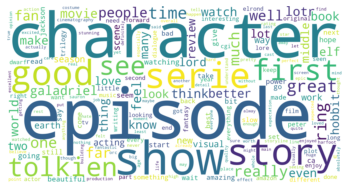

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Creating word_cloud with text as argument in .generate() method

word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                        width = 2048, height = 1080).generate(positive_text)
# saving the image
word_cloud1.to_file('positive_text.png')

plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

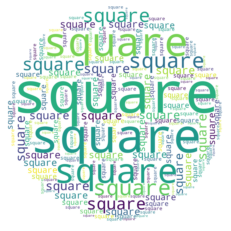

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = "square"

grid_size = 2048
x, y = np.ogrid[:grid_size, :grid_size]

mask = (x - grid_size/2) ** 2 + (y - grid_size/2) ** 2 > (grid_size/2) ** 2
mask = 255 * mask.astype(int)


wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()
